In [7]:
# Enable auto-reload of modified python files.
%load_ext autoreload
%autoreload 2

# packages 
import warnings
import settings
import os
import re as re
import glob 
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import cv2
from scipy.ndimage.filters import maximum_filter
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

# helper functions 
def countX(lst, x):
    count = 0
    for ele in lst:
        if (ele == x):
            count = count + 1
    return count

def clean_image_name(filename):
    return re.findall(r"(.*)\.", filename)[0]

def list_images(IMG_DIRECTORY, img_type):
    image_list = []
    for filename in os.listdir(IMG_DIRECTORY):
        if filename.endswith(img_type):
            image_list.append(clean_image_name(filename))
    return image_list

def merge(list1, list2):
    merged_list = [(list1[i], list2[i]) for i in range(0, len(list1))]
    return merged_list

# design parameters 
img_size = (960, 1280)
vis_ang = 38 
xlim = (640, 1920) # where stim was presented
ylim = (240, 1200)

# target labels
target_labels = ['a-pr1_tongs1','a-pr4_ashtray1', 'a-pr5_dishrag1',
                  'a-pr6_toiletpaper1', 'a-pr10_pillow1', 'a-pr13_coals1',
                  'a-pr14_chalk1','a-pr16_firetools1','a-pr19_umbrella1',
                  'a-pr21_weights1','a-pr22_toycar1', 'a-pr23_pot1',
                  'a-pr26_computer1', 'a-pr30_dvdplayer1','a-pr32_hairdryer1']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# percent of scene foveated by condition
df = pd.read_csv(settings.DATA_PATH + '/fixations.csv')
foveated = []
image = []
participant = []
fixsums = []
trial = []
condition = []
RT = []

for currsub in df.participant.unique():
    currdf = df[df["participant"] == currsub]
    for currim in currdf.image.unique():
        imdf = currdf[currdf["image"] == currim]
        d = np.zeros((img_size[0], img_size[1]), dtype=np.float64)  
        
        # add in each fixation point
        for index,row in imdf.iterrows():
            if xlim [0]< row.x < xlim[1] and ylim[0]< row.y < ylim[1]:
                d[int(row.y - ylim[0]), int(row.x - xlim[0])] += 1
        
        # matrix is upside down, so flip!
        d = np.flipud(d)
        
        # apply uniform filter to array
        filtered = maximum_filter(d, vis_ang*2)
        
        # add percent foveated to list 
        foveated.append((np.count_nonzero(filtered) / filtered.size)*100)
        image.append(currim)
        participant.append(currsub)
        fixsums.append(np.count_nonzero(d))
        trial.append(list(imdf["trial"])[0])
        RT.append((imdf.iloc[-1, 2]- imdf.iloc[0,1]) * 1000)
        if 'C' in row.participant:
            condition.append('memorize')
        else:
            condition.append('search')
del d
# make dictionary of variables then concat to one dataframe            
dictDF = {'participant': participant , 'image': image, 'foveated': foveated,
          'fixSum': fixsums, 'RT':RT, 
          'trial': trial, 'condition': condition,}
results = pd.concat([pd.Series(v, name=k) for k, v in dictDF.items()], axis=1)
del dictDF
searchAVG = results[results["condition"]=='search'].groupby('image').mean().reset_index()
memAVG = results[results["condition"]=='memorize'].groupby('image').mean().reset_index()
del results
# print stats
print('search RT mean',round(searchAVG.RT.mean()/1000, 3), 'sd:',round(searchAVG.RT.std()/1000, 3) )
print('mem RT mean',round(memAVG.RT.mean()/1000, 3), 'sd:',round(memAVG.RT.std()/1000, 3) )
print('search foveated mean:' ,searchAVG['foveated'].mean(), 'std:', searchAVG['foveated'].std(), )
print('mem foveated mean:' ,memAVG['foveated'].mean(), 'std:', memAVG['foveated'].std(), )
print(stats.ranksums(searchAVG["foveated"], memAVG["foveated"]))

search RT mean 3.405 sd: 0.914
mem RT mean 5.885 sd: 0.555
search foveated mean: 3.2179323226686507 std: 0.8911761128833071
mem foveated mean: 4.406912512400793 std: 0.46596248082026503
RanksumsResult(statistic=-3.2975063892427525, pvalue=0.0009754745524558365)


In [3]:
# make target ROIs
m={}
for image_name in list_images(settings.IMG_PATH, '.png'):  
    # pull up xml file
    xml_filename = image_name + '.xml'
    tree = ET.parse(os.path.join(settings.XML_PATH, xml_filename))
    root = tree.getroot()
    objs_in_img = []

    # loop through objects
    for obj in root.findall('object'):
        identity = "nothing"
        
        # check if the object was deleted 
        if obj.find('deleted').text == '0':
            object_name = obj.find('name').text
            object_name = object_name.replace(" ", "")
            objs_in_img.append(object_name)
            
        # give object ID based on how many similiar objects are in scene
            obj_instance = countX(objs_in_img, object_name)
            object_ID = str(image_name)+ '_' + object_name + str(obj_instance)
            
            # check if object is a target and make mask
            if object_ID in target_labels:
                identity = "target"
            if identity != "nothing":
                
                coordinates_x = []
                coordinates_y = []
                
                # loop through coordinates and append to list
                for x in obj.iter('x'):
                    coordinates_x.append(x.text)
                for y in obj.iter('y'):
                    coordinates_y.append(y.text)

                # append first coordinate value to close polygon shape
                coordinates_x.append(coordinates_x[0])
                coordinates_y.append(coordinates_y[0])

                # reshape coordinates
                coordinates = np.array(merge(list(map(int,coordinates_x)), list(map(int,coordinates_y))))
                
                # make empty matrix 
                d = np.zeros((img_size[0], img_size[1]), dtype=np.int32)  
                # make polygon and fill with ones 
                cv2.fillPoly(d, pts=[coordinates], color=(255,255,255))
                 
                key = str(image_name + "_" + identity)
                m[key] = d

In [4]:
# proportion of trial time fixating target 
# stats are time spent on average time on target across 15 images 
# by participant, between condition
df = pd.read_csv(settings.DATA_PATH + '/fixations.csv')

# make fixation duration matrix for every image, all participants 
d = {}
for index,row in df.iterrows():
    if 'C' in row.participant:
        condition = 'memorize'
    else:
        condition = 'search'
    key = str(row.image[:-4] + '_' + condition + '_' + row.participant)

    if key not in d:
        d[key] = np.zeros((img_size[0], img_size[1]), dtype=np.float64)  

    if xlim [0]< row.x < xlim[1] and ylim[0]< row.y < ylim[1]:
        d[key][int(row.y - ylim[0]), int(row.x - xlim[0])] += int(row.dur)
del df 

# for each participant compute fixation duration time on target,
# as proportion of overall trial time
fixdf = pd.DataFrame()
for key in d:
    img, condition, subj = key.split('_')
    fixmap = np.flipud(d[key])
    targetmap = maximum_filter(m[str(img + '_' + 'target')], size=vis_ang)
    targetmap = (targetmap > .5).astype(int) # cleans up the segmentation a bit, but optional
    fixdf = fixdf.append(pd.DataFrame({'image':[img], 'durationTarget': [np.sum(fixmap*targetmap)], 'condition': [condition], 
                                   'participant': [subj], 'totaltime':[np.sum(fixmap)]}))
del d
del m
# average proportion time on target by participant, 
# ranksums to compare between conditions
fixdf['percentTarget'] = (fixdf['durationTarget']/fixdf['totaltime']) 
plotdf = fixdf.groupby(['condition', 'participant']).mean().reset_index()
print('Target search mean:' ,plotdf[plotdf["condition"]=="search"]["percentTarget"].mean(), 'std:', plotdf[plotdf["condition"]=="search"]["percentTarget"].std(), )
print('Target mem mean:' ,plotdf[plotdf["condition"]=="memorize"]["percentTarget"].mean(), 'std:', plotdf[plotdf["condition"]=="memorize"]["percentTarget"].std(), )
print(stats.ranksums(plotdf[plotdf["condition"]=="search"]["percentTarget"],plotdf[plotdf["condition"]=="memorize"]["percentTarget"]))

Target search mean: 0.18859203057348126 std: 0.09461005671649896
Target mem mean: 0.03270536997841158 std: 0.020672008870255287
RanksumsResult(statistic=5.761458208635502, pvalue=8.339031258090976e-09)


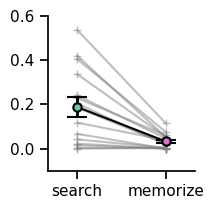

In [6]:
# plot is the average time spent on target by image
sns.set_context("notebook",  font_scale=1)
plotdf = fixdf.groupby(['condition', 'image']).mean().reset_index()
plotdf = plotdf.sort_values(by=['condition', 'image'], ascending=False)
fig, ax = plt.subplots(figsize=(2.25,2.25))
x = [0,.3]
y = [plotdf[plotdf["condition"]=="search"]["percentTarget"].mean(),plotdf[plotdf["condition"]=="memorize"]["percentTarget"].mean()]
error = [stats.sem(plotdf[plotdf["condition"]=="search"]["percentTarget"]), stats.sem(plotdf[plotdf["condition"]=="memorize"]["percentTarget"])]
for currim in plotdf.image.unique():
    currdf = plotdf.loc[plotdf['image']== currim]
    ax.plot(x, currdf['percentTarget'], linestyle="-",marker='+', markersize=6,markeredgewidth=1,  color='gray', 
             markeredgecolor="gray",  alpha=.5,linewidth=1.5,  markerfacecolor='none')
plt.plot([0,.3],[y[0],y[1]],linestyle="-",  color='black' )
plt.errorbar(0, y[0],
             yerr = error[0],  fmt='o', color='mediumaquamarine', 
           markersize=6,capsize=7, markeredgecolor='black',
             elinewidth=2, markeredgewidth=1.5, ecolor='black')
plt.errorbar(.3, y[1],
             yerr = error[1],  fmt='o', color='orchid', 
             markersize=6,capsize=7, markeredgecolor='black',
             elinewidth=2, markeredgewidth=1.5, ecolor='black')
ax.set_xticks([0,.3], labels=['search','memorize'])
ax.set_xlim([-.1, .4])
ax.set_ylim([-0.1,.6])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig(settings.RESULTS_PATH + '/figure6/6a.svg', dpi=1000)